Name: Danial Ahangarani

Student ID: 400211546

In this practical assignment, we will develope a U-Net for semantis segmentation of lung CT-scans.

For this task, you will use a dataset consisting of CT-scans from lungs of COVID-19 patients. The regions affected by COVID-19 are marked with labels of ground glass opacity. You will be training and testing the U-Net model on this dataset.

# Training for All four masks.

## Imports

In [ ]:
!pip install livelossplot --quiet

In [ ]:
# Import any needed packages here
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF

from tqdm import tqdm
import torchvision 
import torch.nn.functional as F

import numpy as np
from matplotlib import pyplot as plt
from google.colab import drive

from livelossplot import PlotLosses

## Prepare and Visualize Data
Now download and unzip the data. (Note: If you face any problems for downloading uzing gdown and unzipping, you may also download the data manually using the Goggle Drive links in the code)

In [ ]:
# Mount Drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# I just downloaded images and masks files manualy and put them on my google drive.
images = np.load('/content/gdrive/MyDrive/images_medseg.npy').astype(np.float32)
masks = np.load('/content/gdrive/MyDrive/masks_medseg.npy').astype(np.float32)

In [ ]:
print("Images Shape:", images.shape)
print("Masks Shape:", masks.shape)

Images Shape: (100, 512, 512, 1)
Masks Shape: (100, 512, 512, 4)


In [ ]:
# Normalize images
def normalize_img(img):
    img = img.astype("float32")
    img[img > 500] = 500
    img[img < -1500] = -1500
    min_perc, max_perc = np.percentile(img, 5), np.percentile(img, 95)
    img_valid = img[(img > min_perc) & (img < max_perc)]
    mean, std = img_valid.mean(), img_valid.std()
    img = (img-mean)/std
    return img

images = normalize_img(images)

The dataset consists of 100 CT images with size 512*512. In the Masks data,for each image 4 masks are provided with different meanings. The first mask (index 0) is the ground glass opacity class, indicating the regions affected by COVID-19. Also, the last mask (index 4) is the background class.

You can see the visulaiztion of a few of the CT images, and their given masks using the code below. In this assignment, use the first mask (ground glass opacity) for the segmentation task (You may also test it on other classes if you like too!)

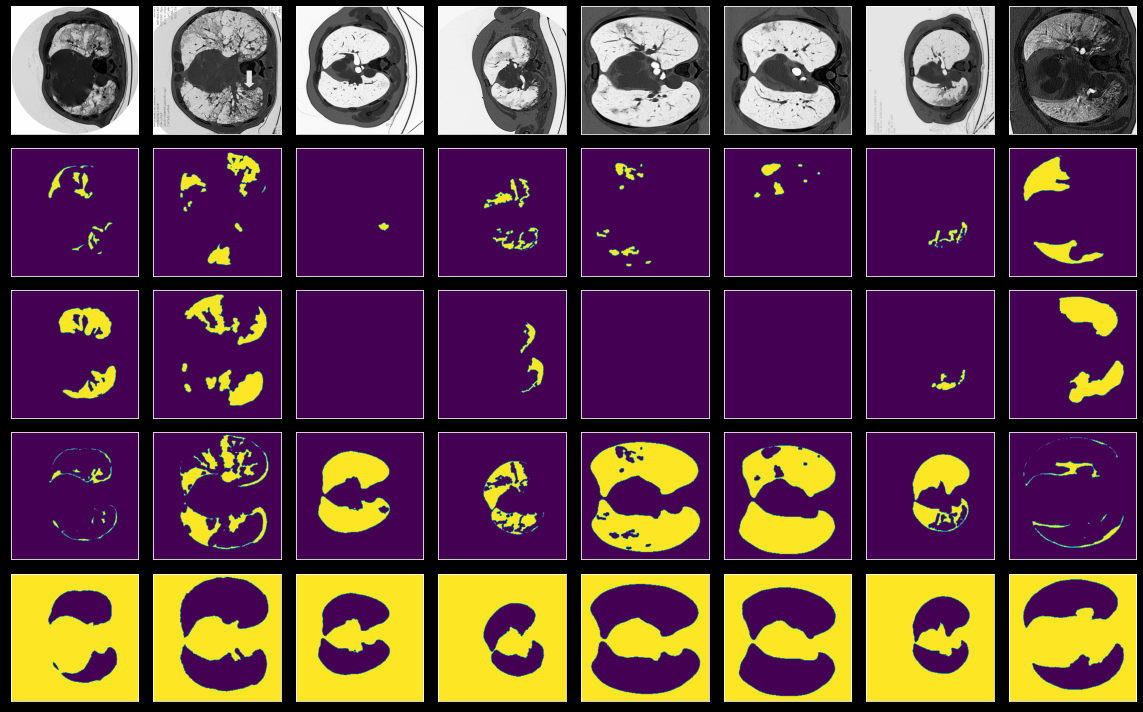

In [ ]:
plt.style.use("dark_background")

def visualize(image_batch, mask_batch=None, pred_batch=None, num_samples=8):
    num_classes = mask_batch.shape[-1] if mask_batch is not None else 0
    fix, ax = plt.subplots(num_classes + 1, num_samples, figsize=(num_samples * 2, (num_classes + 1) * 2))
    for i in range(num_samples):
        ax_image = ax[0, i] if num_classes > 0 else ax[i]
        ax_image.imshow(image_batch[i,:,:,0], cmap="Greys")
        ax_image.set_xticks([]) 
        ax_image.set_yticks([])
        
        if mask_batch is not None:
            for j in range(num_classes):
                if pred_batch is None:
                    #print(j)
                    mask_to_show = mask_batch[i,:,:,j]
                else:
                    mask_to_show = np.zeros(shape=(*mask_batch.shape[1:-1], 3)) 
                    mask_to_show[..., 0] = pred_batch[i,:,:,j] > 0.5
                    mask_to_show[..., 1] = mask_batch[i,:,:,j]
                ax[j + 1, i].imshow(mask_to_show, vmin=0, vmax=1)
                ax[j + 1, i].set_xticks([]) 
                ax[j + 1, i].set_yticks([]) 

    plt.tight_layout()
    plt.show()

visualize(images, masks)

## Create Your Dataset Class (10%)

In [ ]:
class CTDataset(torch.utils.data.Dataset):
    def __init__(self, images, masks):

        self.images = images
        self.masks = masks
        self.n_samples = len(images)

    def __getitem__(self, idx):
        
        """ Reading image """
        image = self.images[idx]
        image = image[:,:,]
        image = np.transpose(image, (2,0,1)) 
        image = image.astype(np.float32)
        image = torch.from_numpy(image)

        """ Reading mask """
        mask = self.masks[idx]
        mask = mask[:,:,]
        #mask = np.expand_dims(mask, axis = 0)
        mask = np.transpose(mask, (2,0,1)) 
        mask = mask.astype(np.float32)
        mask = torch.from_numpy(mask)

        return image, mask

    def __len__(self):
        return self.n_samples

# TODO: Instatntiate your dataset here
dataset = CTDataset(images, masks)

## Split Dataset and Dataloader (5%)

In this part, split the dataset (80% train, 10% validation, 10% test). Then, create your train and validation DataLoader, using random shuffle and batch size of 4.

In [ ]:
from torch.utils.data import random_split
from torch.utils.data import DataLoader, Dataset

train_dataset, val_dataset, test_dataset = random_split(dataset,[.8, .1, .1])

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=True)

## Implement your U-Net (45%)

In this section implement your U-Net model, inherited from torch.nn.Module.

In the next text cell, explain the architecture of the implemented U-Net. Then, complete the code cell to creat your class.

In [ ]:
from torch.nn import ConvTranspose2d
from torch.nn import Conv2d
from torch.nn import MaxPool2d
from torch.nn import Module
from torch.nn import ModuleList
from torch.nn import ReLU
from torchvision.transforms import CenterCrop
from torch.nn import functional as F
import torch

In [ ]:
class Block(Module):
	def __init__(self, inChannels, outChannels):
		super().__init__()
		self.conv1 = Conv2d(inChannels, outChannels, 3)
		self.relu = ReLU()
		self.conv2 = Conv2d(outChannels, outChannels, 3)
	def forward(self, x):
		return self.conv2(self.relu(self.conv1(x)))

In [ ]:
class Encoder(Module):
	def __init__(self, channels=(1, 16, 32, 64)):
		super().__init__()
		self.encBlocks = ModuleList(
			[Block(channels[i], channels[i + 1])
			 	for i in range(len(channels) - 1)])
		self.pool = MaxPool2d(2)
	def forward(self, x):
		blockOutputs = []
		for block in self.encBlocks:
			x = block(x)
			blockOutputs.append(x)
			x = self.pool(x)
		return blockOutputs

In [ ]:
class Decoder(Module):
	def __init__(self, channels=(64, 32, 16)):
		super().__init__()
		self.channels = channels
		self.upconvs = ModuleList(
			[ConvTranspose2d(channels[i], channels[i + 1], 2, 2)
			 	for i in range(len(channels) - 1)])
		self.dec_blocks = ModuleList(
			[Block(channels[i], channels[i + 1])
			 	for i in range(len(channels) - 1)])
	def forward(self, x, encFeatures):
		for i in range(len(self.channels) - 1):
			x = self.upconvs[i](x)
			encFeat = self.crop(encFeatures[i], x)
			x = torch.cat([x, encFeat], dim=1)
			x = self.dec_blocks[i](x)
		return x
	def crop(self, encFeatures, x):
		(_, _, H, W) = x.shape
		encFeatures = CenterCrop([H, W])(encFeatures)
		return encFeatures
  


In [ ]:
class UNet(Module):
    def __init__(self, encChannels=(1, 16, 32, 64),
          decChannels=(64, 32, 16),
          nbClasses=4, retainDim=True,
          outSize=(512,  512)):
        super().__init__()
        self.encoder = Encoder(encChannels)
        self.decoder = Decoder(decChannels)
        self.head = Conv2d(decChannels[-1], nbClasses, 1)
        self.retainDim = retainDim
        self.outSize = outSize

    def forward(self, x):
        encFeatures = self.encoder(x)
        decFeatures = self.decoder(encFeatures[::-1][0],
          encFeatures[::-1][1:])
        map = self.head(decFeatures)
        if self.retainDim:
          map = F.interpolate(map, self.outSize)
        return map

The UNet architecture consists of two parts: a contracting path (encoder) and an expansive path (decoder). The contraction path follows the typical architecture of a convolutional neural network based on the VGG-16 model, consisting of repeated modules of two 3x3 convolutions, a ReLU activation function and 2x2 max pooling operations with stride 2 for downsampling. In contrast, each step in the expanding path consists of an upsampling of features followed by two 3x3 convolutional layers, each followed by a ReLU activation and then concatenated with correspondingly cropped feature map from the contracting path. This allows precise localization as well as contextual information to be combined while segmenting areas.

## IOU (5%)
In this section, implement the function calculating IOU (Intersection Over Union) for a given prediction (your model's output) and target (ground-truth labels).

In [ ]:
import tensorflow as tf
def Iou(true_y, pred_y):
    def f(true_y, pred_y):
        intersection = (true_y * pred_y).sum()
        union = true_y.sum() + pred_y.sum() - intersection
        x = (intersection)/(union)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [true_y, pred_y], tf.float32)

## Train and test function (25%), Define your model, optimizer, and loss function (5%)

Train your model for a desired number of epochs (at least 15). At each epoch, run your model on the validation data (reporting the loss and IOU value), and save the model which has the best average IOU on the validation set. Finally, report the average IOU on the target data.

During training, also plot the train loss values, average IOU on the train data, and avergae IOU on the validation data per epochs.

Instantiate your model. Also, set your optimizer to Adam optimizer, and your criterion to Bincry Cross-Entropy Loss.

In [ ]:
def check_accuracy(best_val_iou, epoch_num, loader, model, device='cuda'):
  num_correct = 0
  num_pixels = 0
  dice_score = 0
  iou = 0
  model.eval()
  iou2 = 0
  with torch.no_grad():
    for x, y in loader:
      x = x.to(device)
      y = y.to(device)
      preds = torch.sigmoid(model(x))
      preds = (preds > .5).float()
      lbl = y.cpu().numpy()
      targe = preds.cpu().numpy()
      num_correct += (preds == y).sum()
      num_pixels += torch.numel(preds)
      dice_score += (2*(preds*y).sum()) / ((preds + y).sum() )
      iou2 += Iou(lbl, targe)

  miou = iou2/len(loader)
  logs['avergae IOU on validation set'] = miou
  if miou > best_val_iou: 
    best_val_iou =miou
    torch.save({
            'epoch': epoch_num,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'miou': miou,
            }, 'model.pt')

  model.train()
  return best_val_iou

In [ ]:
def train_fn(train_dataloader, model, optimizer, loss_fn, scaler, logs):
  loop = tqdm(train_dataloader)

  for batch_idx, (data, targets) in enumerate(loop):
    data = data.to(device=DEVICE)
    targets = targets.float().to(device=DEVICE)

    # forward
    with torch.cuda.amp.autocast():
      predictions = model(data)
      loss = loss_fn(predictions, targets)
    
    # backward
    optimizer.zero_grad()
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()

    # update tqdm loop
    loop.set_postfix(loss=loss.item())
  logs['training loss'] = loss.item()

            

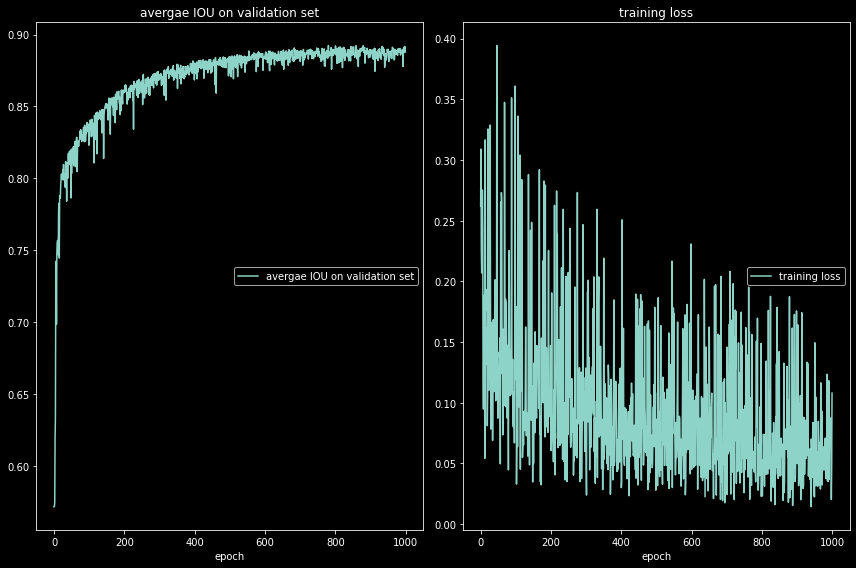

avergae IOU on validation set
	avergae IOU on validation set 	 (min:    0.572, max:    0.892, cur:    0.888)
training loss
	training loss    	 (min:    0.014, max:    0.394, cur:    0.108)


In [ ]:
import torch.optim as optim
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet()
liveloss = PlotLosses()
model.to(DEVICE)
num_epochs = 1000
optimizer = optim.Adam(model.parameters(), lr = 1e-4)
loss_fn = nn.BCEWithLogitsLoss()
best_val_iou = 0
scaler = torch.cuda.amp.GradScaler()

for epoch in range(num_epochs):
  logs = {}
  train_fn(trainloader, model, optimizer, loss_fn, scaler, logs)
  best_val_iou = check_accuracy(best_val_iou, epoch, valloader, model, device=DEVICE)
  liveloss.update(logs)
  liveloss.send()


## Visualize the models output on 4 of target images (5%)

Run the model on 4 samples from the target set. Visualize the outcome by plotting the groud-truth labels, model's predicition, and the difference between them.

In [ ]:
# TODO: Run the model on 4 samples from target set, Visualize the labels and predictions, and compare them
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)

In [ ]:


import matplotlib.pyplot as plt
import numpy as np
import torch
import cv2
import os
def prepare_plot(origImage, origMask, predMask):
	# initialize our figure
	figure, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))
	# plot the original image, its mask, and the predicted mask
	ax[0].imshow(origImage)
	ax[1].imshow(origMask) 
	ax[2].imshow(predMask)
	# set the titles of the subplots
	ax[0].set_title("Image")
	ax[1].set_title("Original Mask")
	ax[2].set_title("Predicted Mask")
	ax[0].axis('off')
	ax[1].axis('off')
	ax[2].axis('off')

	# set the layout of the figure and display it
	figure.tight_layout()
	figure.show()

In [ ]:
def make_predictions(model, imge, target):
    iou = 0
    # set model to evaluation mode
    model.eval()
    # turn off gradient tracking
    with torch.no_grad():

      image = imge.to(DEVICE)
      
      predMask = model(image).squeeze()
      predMask = torch.sigmoid(predMask)
      predMask = predMask.cpu().numpy()

      image = image[0,0,:,:].cpu().numpy()
      target = target.numpy()
      iou = Iou(target, predMask)
      prepare_plot(image, target[0,0,:,:], predMask[0,:,:])

    return iou


100%|██████████| 10/10 [00:00<00:00, 12.28it/s]


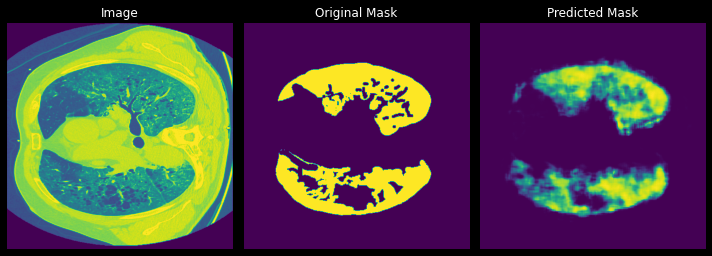

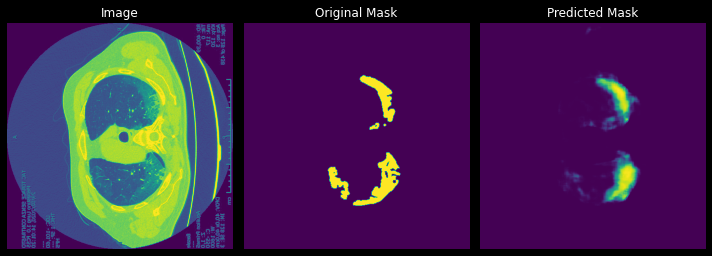

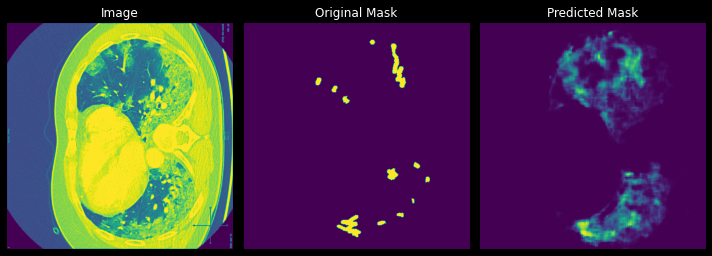

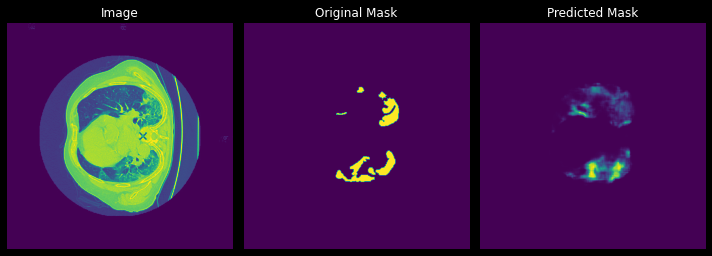

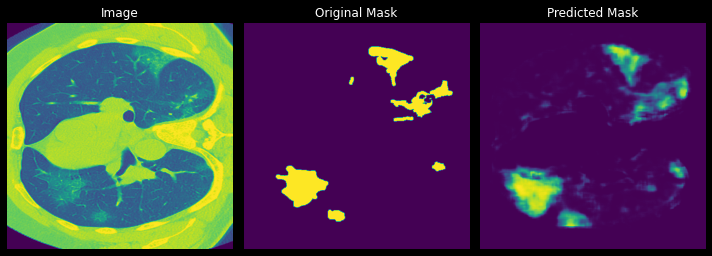

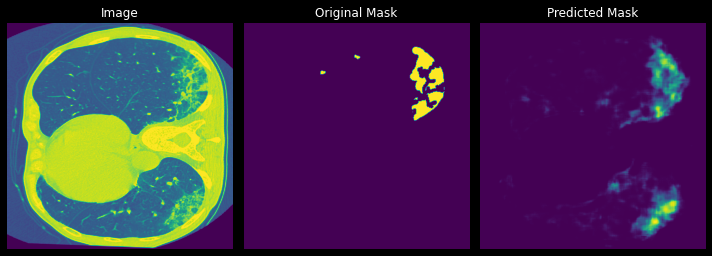

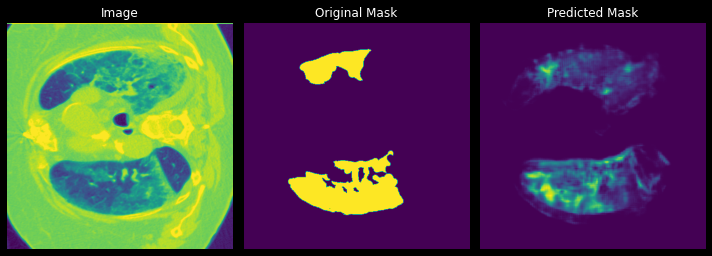

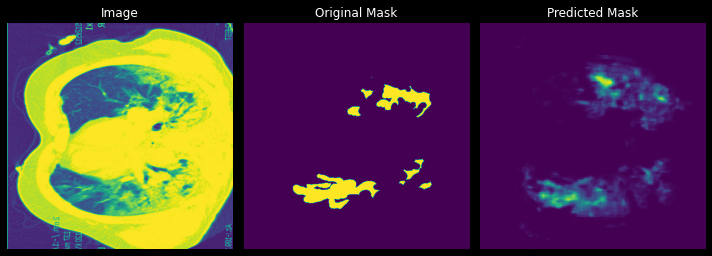

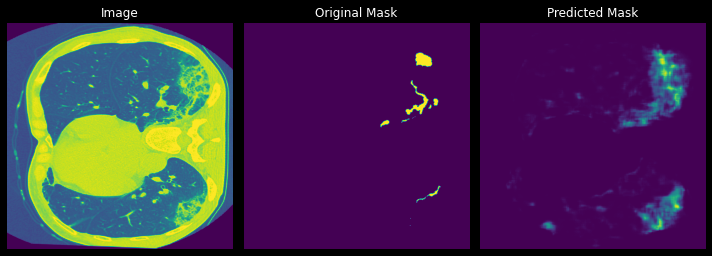

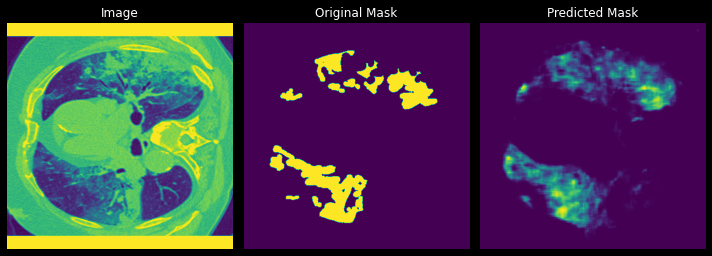

In [ ]:
loop = tqdm(testloader) 
test_iou = 0
for batch_idx, (data, targets) in enumerate(loop):
  test_iou += make_predictions(model, data, targets)

In [ ]:
print(f'Test IOU: {test_iou/len(testloader)}')

Test IOU: 0.8013449907302856


## Improve U-Net (Bonus) (10%)

In this bnous part, you can add your ideas for improving your model's performance. As an idea, you can search about exploiting IOU metric in the loss function. (you may use other ideas as well!) 

# Training for Last mask.

## Imports

In [1]:
!pip install livelossplot --quiet

In [2]:
# Import any needed packages here
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF

from tqdm import tqdm
import torchvision 
import torch.nn.functional as F

import numpy as np
from matplotlib import pyplot as plt
from google.colab import drive

from livelossplot import PlotLosses

## Prepare and Visualize Data
Now download and unzip the data. (Note: If you face any problems for downloading uzing gdown and unzipping, you may also download the data manually using the Goggle Drive links in the code)

In [3]:
# Mount Drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
# I just downloaded images and masks files manualy and put them on my google drive.
images = np.load('/content/gdrive/MyDrive/images_medseg.npy').astype(np.float32)
masks = np.load('/content/gdrive/MyDrive/masks_medseg.npy').astype(np.float32)

In [5]:
print("Images Shape:", images.shape)
print("Masks Shape:", masks.shape)

Images Shape: (100, 512, 512, 1)
Masks Shape: (100, 512, 512, 4)


In [6]:
# Normalize images
def normalize_img(img):
    img = img.astype("float32")
    img[img > 500] = 500
    img[img < -1500] = -1500
    min_perc, max_perc = np.percentile(img, 5), np.percentile(img, 95)
    img_valid = img[(img > min_perc) & (img < max_perc)]
    mean, std = img_valid.mean(), img_valid.std()
    img = (img-mean)/std
    return img

images = normalize_img(images)

The dataset consists of 100 CT images with size 512*512. In the Masks data,for each image 4 masks are provided with different meanings. The first mask (index 0) is the ground glass opacity class, indicating the regions affected by COVID-19. Also, the last mask (index 4) is the background class.

You can see the visulaiztion of a few of the CT images, and their given masks using the code below. In this assignment, use the first mask (ground glass opacity) for the segmentation task (You may also test it on other classes if you like too!)

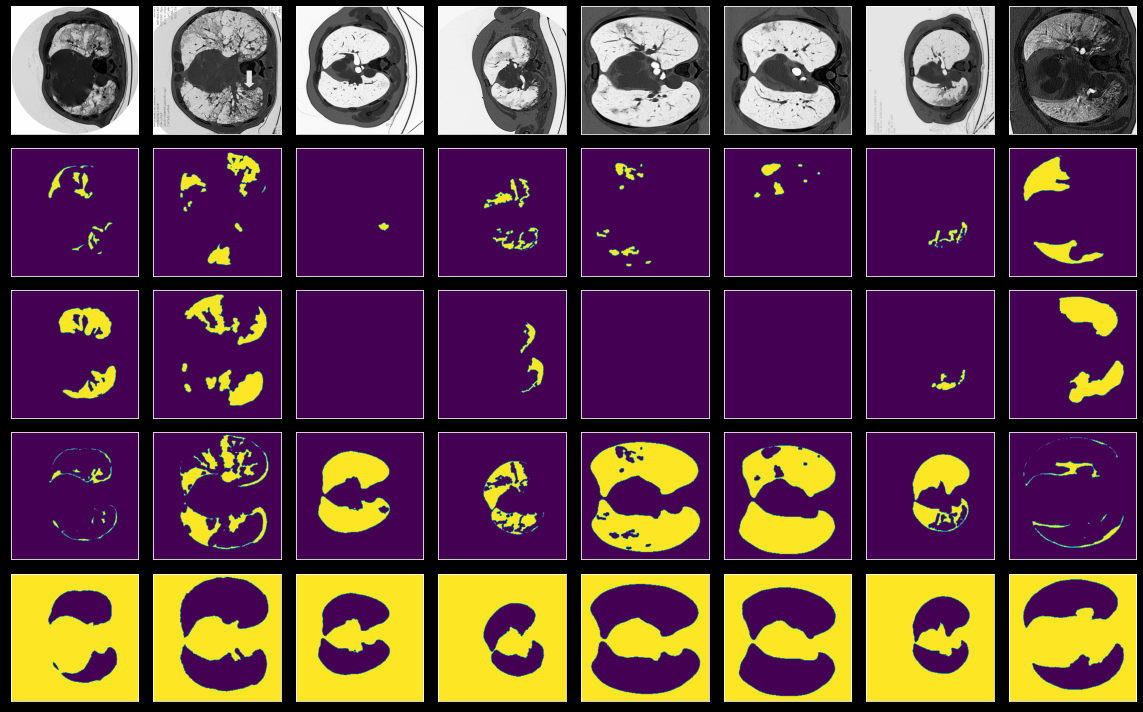

In [7]:
plt.style.use("dark_background")

def visualize(image_batch, mask_batch=None, pred_batch=None, num_samples=8):
    num_classes = mask_batch.shape[-1] if mask_batch is not None else 0
    fix, ax = plt.subplots(num_classes + 1, num_samples, figsize=(num_samples * 2, (num_classes + 1) * 2))
    for i in range(num_samples):
        ax_image = ax[0, i] if num_classes > 0 else ax[i]
        ax_image.imshow(image_batch[i,:,:,0], cmap="Greys")
        ax_image.set_xticks([]) 
        ax_image.set_yticks([])
        
        if mask_batch is not None:
            for j in range(num_classes):
                if pred_batch is None:
                    #print(j)
                    mask_to_show = mask_batch[i,:,:,j]
                else:
                    mask_to_show = np.zeros(shape=(*mask_batch.shape[1:-1], 3)) 
                    mask_to_show[..., 0] = pred_batch[i,:,:,j] > 0.5
                    mask_to_show[..., 1] = mask_batch[i,:,:,j]
                ax[j + 1, i].imshow(mask_to_show, vmin=0, vmax=1)
                ax[j + 1, i].set_xticks([]) 
                ax[j + 1, i].set_yticks([]) 

    plt.tight_layout()
    plt.show()

visualize(images, masks)

## Create Your Dataset Class (10%)

In [8]:
class CTDataset(torch.utils.data.Dataset):
    def __init__(self, images, masks):

        self.images = images
        self.masks = masks
        self.n_samples = len(images)

    def __getitem__(self, idx):
        
        """ Reading image """
        image = self.images[idx]
        image = image[:,:,]
        image = np.transpose(image, (2,0,1)) 
        image = image.astype(np.float32)
        image = torch.from_numpy(image)

        """ Reading mask """
        mask = self.masks[idx]
        mask = mask[:,:,3]
        mask = np.expand_dims(mask, axis = 0)
        #mask = np.transpose(mask, (2,0,1)) 
        mask = mask.astype(np.float32)
        mask = torch.from_numpy(mask)

        return image, mask

    def __len__(self):
        return self.n_samples

# TODO: Instatntiate your dataset here
dataset = CTDataset(images, masks)

## Split Dataset and Dataloader (5%)

In this part, split the dataset (80% train, 10% validation, 10% test). Then, create your train and validation DataLoader, using random shuffle and batch size of 4.

In [9]:
from torch.utils.data import random_split
from torch.utils.data import DataLoader, Dataset

train_dataset, val_dataset, test_dataset = random_split(dataset,[.8, .1, .1])

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=True)

## Implement your U-Net (45%)

In this section implement your U-Net model, inherited from torch.nn.Module.

In the next text cell, explain the architecture of the implemented U-Net. Then, complete the code cell to creat your class.

In [10]:
from torch.nn import ConvTranspose2d
from torch.nn import Conv2d
from torch.nn import MaxPool2d
from torch.nn import Module
from torch.nn import ModuleList
from torch.nn import ReLU
from torchvision.transforms import CenterCrop
from torch.nn import functional as F
import torch

In [11]:
class Block(Module):
	def __init__(self, inChannels, outChannels):
		super().__init__()
		self.conv1 = Conv2d(inChannels, outChannels, 3)
		self.relu = ReLU()
		self.conv2 = Conv2d(outChannels, outChannels, 3)
	def forward(self, x):
		return self.conv2(self.relu(self.conv1(x)))

In [12]:
class Encoder(Module):
	def __init__(self, channels=(1, 16, 32, 64)):
		super().__init__()
		self.encBlocks = ModuleList(
			[Block(channels[i], channels[i + 1])
			 	for i in range(len(channels) - 1)])
		self.pool = MaxPool2d(2)
	def forward(self, x):
		blockOutputs = []
		for block in self.encBlocks:
			x = block(x)
			blockOutputs.append(x)
			x = self.pool(x)
		return blockOutputs

In [13]:
class Decoder(Module):
	def __init__(self, channels=(64, 32, 16)):
		super().__init__()
		self.channels = channels
		self.upconvs = ModuleList(
			[ConvTranspose2d(channels[i], channels[i + 1], 2, 2)
			 	for i in range(len(channels) - 1)])
		self.dec_blocks = ModuleList(
			[Block(channels[i], channels[i + 1])
			 	for i in range(len(channels) - 1)])
	def forward(self, x, encFeatures):
		for i in range(len(self.channels) - 1):
			x = self.upconvs[i](x)
			encFeat = self.crop(encFeatures[i], x)
			x = torch.cat([x, encFeat], dim=1)
			x = self.dec_blocks[i](x)
		return x
	def crop(self, encFeatures, x):
		(_, _, H, W) = x.shape
		encFeatures = CenterCrop([H, W])(encFeatures)
		return encFeatures
  


In [14]:
class UNet(Module):
    def __init__(self, encChannels=(1, 16, 32, 64),
          decChannels=(64, 32, 16),
          nbClasses=1, retainDim=True,
          outSize=(512,  512)):
        super().__init__()
        self.encoder = Encoder(encChannels)
        self.decoder = Decoder(decChannels)
        self.head = Conv2d(decChannels[-1], nbClasses, 1)
        self.retainDim = retainDim
        self.outSize = outSize

    def forward(self, x):
        encFeatures = self.encoder(x)
        decFeatures = self.decoder(encFeatures[::-1][0],
          encFeatures[::-1][1:])
        map = self.head(decFeatures)
        if self.retainDim:
          map = F.interpolate(map, self.outSize)
        return map

The UNet architecture consists of two parts: a contracting path (encoder) and an expansive path (decoder). The contraction path follows the typical architecture of a convolutional neural network based on the VGG-16 model, consisting of repeated modules of two 3x3 convolutions, a ReLU activation function and 2x2 max pooling operations with stride 2 for downsampling. In contrast, each step in the expanding path consists of an upsampling of features followed by two 3x3 convolutional layers, each followed by a ReLU activation and then concatenated with correspondingly cropped feature map from the contracting path. This allows precise localization as well as contextual information to be combined while segmenting areas.

## IOU (5%)
In this section, implement the function calculating IOU (Intersection Over Union) for a given prediction (your model's output) and target (ground-truth labels).

In [15]:
import tensorflow as tf
def Iou(true_y, pred_y):
    def f(true_y, pred_y):
        intersection = (true_y * pred_y).sum()
        union = true_y.sum() + pred_y.sum() - intersection
        x = (intersection)/(union)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [true_y, pred_y], tf.float32)

## Train and test function (25%), Define your model, optimizer, and loss function (5%)

Train your model for a desired number of epochs (at least 15). At each epoch, run your model on the validation data (reporting the loss and IOU value), and save the model which has the best average IOU on the validation set. Finally, report the average IOU on the target data.

During training, also plot the train loss values, average IOU on the train data, and avergae IOU on the validation data per epochs.

Instantiate your model. Also, set your optimizer to Adam optimizer, and your criterion to Bincry Cross-Entropy Loss.

In [16]:
def check_accuracy(best_val_iou, epoch_num, loader, model, device='cuda'):
  num_correct = 0
  num_pixels = 0
  dice_score = 0
  iou = 0
  model.eval()
  iou2 = 0
  with torch.no_grad():
    for x, y in loader:
      x = x.to(device)
      y = y.to(device)
      preds = torch.sigmoid(model(x))
      preds = (preds > .5).float()
      lbl = y.cpu().numpy()
      targe = preds.cpu().numpy()
      num_correct += (preds == y).sum()
      num_pixels += torch.numel(preds)
      dice_score += (2*(preds*y).sum()) / ((preds + y).sum() )
      iou2 += Iou(lbl, targe)

  miou = iou2/len(loader)
  logs['avergae IOU on validation set'] = miou
  if miou > best_val_iou: 
    best_val_iou =miou
    torch.save({
            'epoch': epoch_num,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'miou': miou,
            }, 'model.pt')

  model.train()
  return best_val_iou

In [17]:
def train_fn(train_dataloader, model, optimizer, loss_fn, scaler, logs):
  loop = tqdm(train_dataloader)

  for batch_idx, (data, targets) in enumerate(loop):
    data = data.to(device=DEVICE)
    targets = targets.float().to(device=DEVICE)

    # forward
    with torch.cuda.amp.autocast():
      predictions = model(data)
      loss = loss_fn(predictions, targets)
    
    # backward
    optimizer.zero_grad()
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()

    # update tqdm loop
    loop.set_postfix(loss=loss.item())
  logs['training loss'] = loss.item()

            

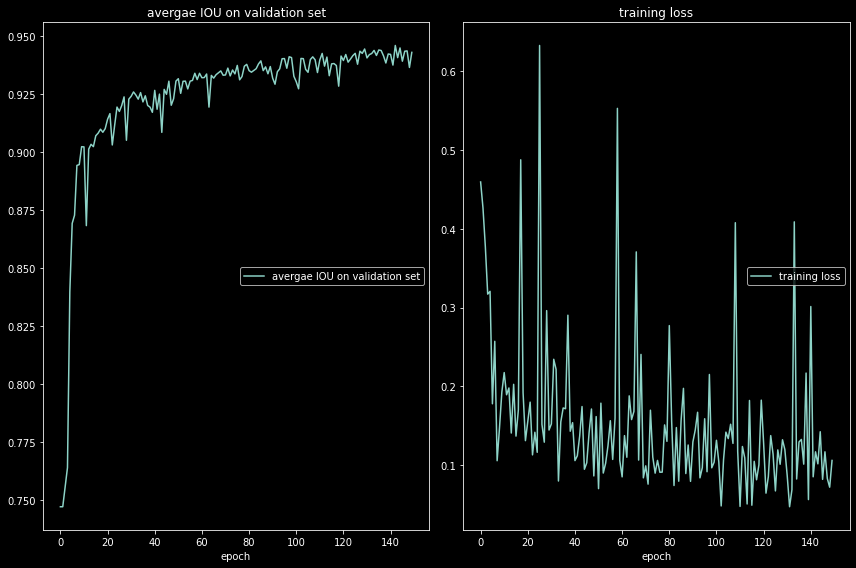

avergae IOU on validation set
	avergae IOU on validation set 	 (min:    0.747, max:    0.946, cur:    0.943)
training loss
	training loss    	 (min:    0.047, max:    0.633, cur:    0.106)


In [19]:
import torch.optim as optim
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet()
liveloss = PlotLosses()
model.to(DEVICE)
num_epochs = 150
optimizer = optim.Adam(model.parameters(), lr = 1e-4)
loss_fn = nn.BCEWithLogitsLoss()
best_val_iou = 0
scaler = torch.cuda.amp.GradScaler()

for epoch in range(num_epochs):
  logs = {}
  train_fn(trainloader, model, optimizer, loss_fn, scaler, logs)
  best_val_iou = check_accuracy(best_val_iou, epoch, valloader, model, device=DEVICE)
  liveloss.update(logs)
  liveloss.send()


## Visualize the models output on 4 of target images (5%)

Run the model on 4 samples from the target set. Visualize the outcome by plotting the groud-truth labels, model's predicition, and the difference between them.

In [41]:
# TODO: Run the model on 4 samples from target set, Visualize the labels and predictions, and compare them
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)

In [42]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import cv2
import os
def prepare_plot(origImage, origMask, predMask):
	# initialize our figure
	figure, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))
	# plot the original image, its mask, and the predicted mask
	ax[0].imshow(origImage)
	ax[1].imshow(origMask) 
	ax[2].imshow(predMask)
	# set the titles of the subplots
	ax[0].set_title("Image")
	ax[1].set_title("Original Mask")
	ax[2].set_title("Predicted Mask")
	ax[0].axis('off')
	ax[1].axis('off')
	ax[2].axis('off')

	# set the layout of the figure and display it
	figure.tight_layout()
	figure.show()

In [43]:
def make_predictions(model, imge, target):
    iou = 0
    # set model to evaluation mode
    model.eval()
    # turn off gradient tracking
    with torch.no_grad():

      image = imge.to(DEVICE)
      
      predMask = model(image).squeeze()
      predMask = torch.sigmoid(predMask)
      predMask = predMask.cpu().numpy()

      image = image[0,0,:,:].cpu().numpy()
      target = target.numpy()
      iou = Iou(target, predMask)
      prepare_plot(image, target[0,0,:,:], predMask[:,:])

    return iou


100%|██████████| 10/10 [00:00<00:00, 12.91it/s]


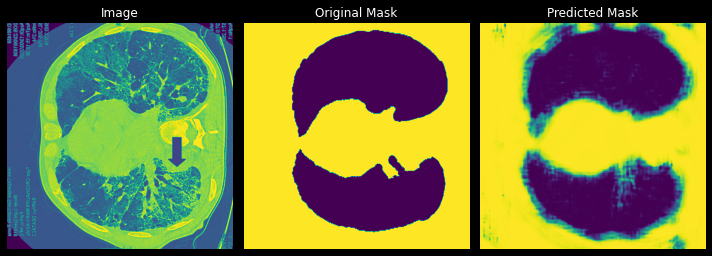

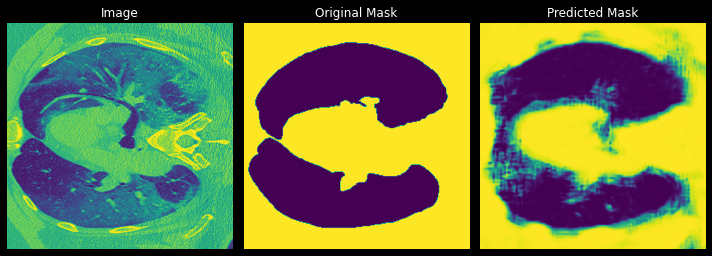

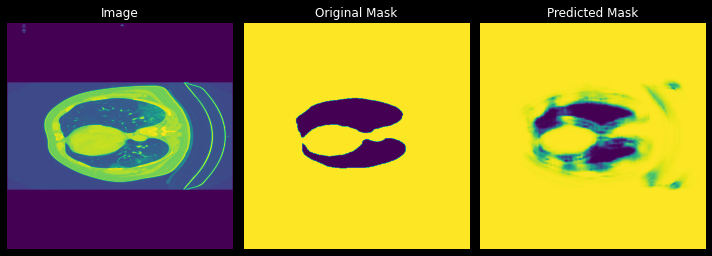

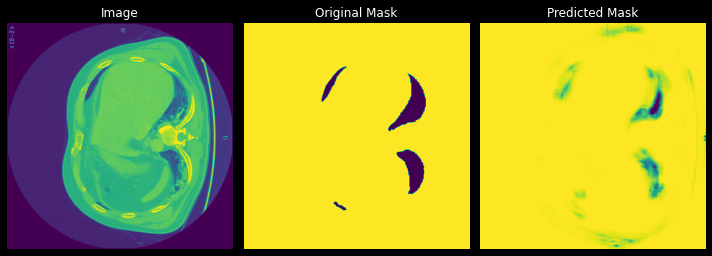

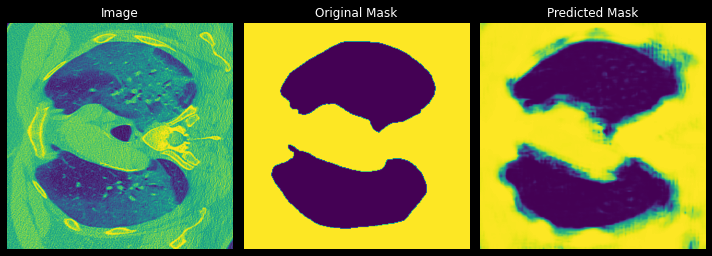

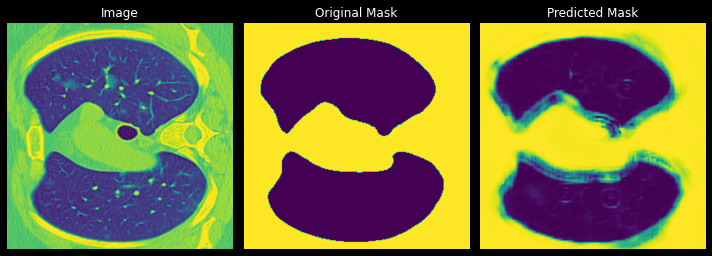

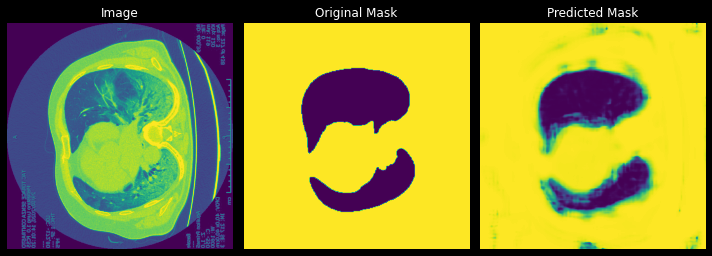

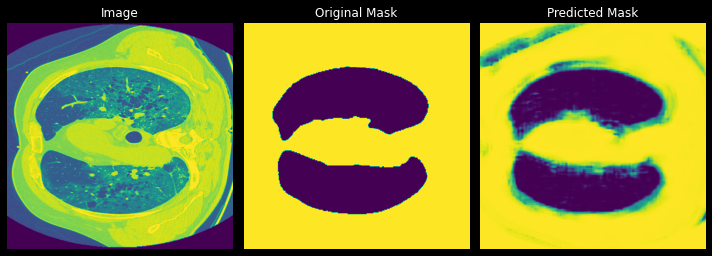

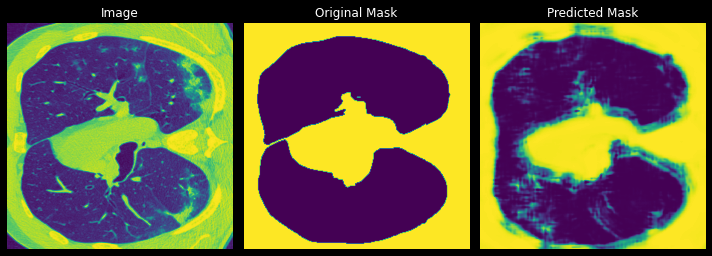

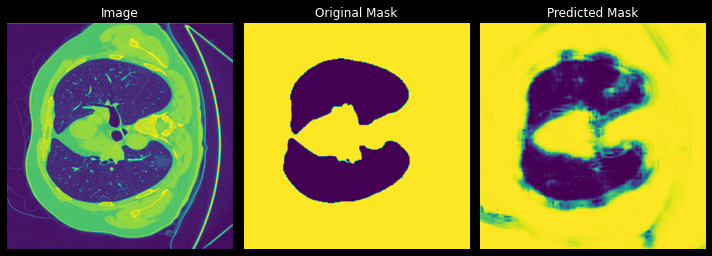

In [44]:
loop = tqdm(testloader) 
test_iou = 0
for batch_idx, (data, targets) in enumerate(loop):
  test_iou += make_predictions(model, data, targets)

In [45]:
print(f'Test IOU: {test_iou/len(testloader)}')

Test IOU: 0.8989278674125671


## Improve U-Net (Bonus) (10%)

In this bnous part, you can add your ideas for improving your model's performance. As an idea, you can search about exploiting IOU metric in the loss function. (you may use other ideas as well!) 